# Causal Learning

## Imports

In [72]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
#from causalnex.utils.network_utils import get_markov_blanket
from causalnex.network import BayesianNetwork 
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

In [73]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [74]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [75]:
from file_handler import FileHandler
import vis_seaborn as vs
from eda_helper import Helper
from df_overview import DfOverview
from ScalerNormalizer import ScalerNormalizer

In [76]:
helper = Helper()
sn = ScalerNormalizer()

## Data reading

In [77]:
fh = FileHandler()
df = fh.read_csv("../data/data.csv")
df.head(5)

INFO:file_handler:Csv file read from ../data/data.csv.


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.23,0.28,0.15,0.24,0.08,0.85,0.91,5.98,86.20,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,1937.05,0.16,0.63,0.71,0.27,0.42,0.12
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1937.05,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,86.20,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,M,11.42,20.38,77.58,386.10,0.13,0.23,0.24,0.11,0.25,0.08,0.50,1.16,3.44,27.23,0.01,0.06,0.06,0.02,0.04,0.01,14.91,26.50,98.87,567.70,0.19,0.63,0.69,0.26,0.42,0.12
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,86.20,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [78]:
feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']

In [79]:
x = df[feat[:29]]
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,184.60,1937.05,25.38,0.27,0.15,122.80,1001.00,17.99,86.20,0.28,0.71,5.98,0.85,0.63,0.23,17.33,0.02,0.16,10.38,0.42,0.05,0.12,0.24,0.05,0.12,0.01,0.91,0.08
1,1,158.80,1937.05,24.99,0.19,0.07,132.90,1326.00,20.57,74.08,0.09,0.24,3.40,0.54,0.19,0.08,23.41,0.01,0.12,17.77,0.28,0.02,0.08,0.18,0.01,0.09,0.00,0.73,0.06
2,1,152.50,1709.00,23.57,0.24,0.13,130.00,1203.00,19.69,86.20,0.20,0.45,4.58,0.75,0.42,0.16,25.53,0.02,0.14,21.25,0.36,0.04,0.11,0.21,0.04,0.09,0.00,0.79,0.06
3,1,98.87,567.70,14.91,0.26,0.11,77.58,386.10,11.42,27.23,0.24,0.69,3.44,0.50,0.63,0.23,26.50,0.02,0.19,20.38,0.42,0.06,0.13,0.25,0.06,0.12,0.01,1.16,0.08
4,1,152.20,1575.00,22.54,0.16,0.10,135.10,1297.00,20.29,86.20,0.20,0.40,5.44,0.76,0.20,0.13,16.67,0.02,0.14,14.34,0.24,0.06,0.10,0.18,0.02,0.08,0.01,0.78,0.06


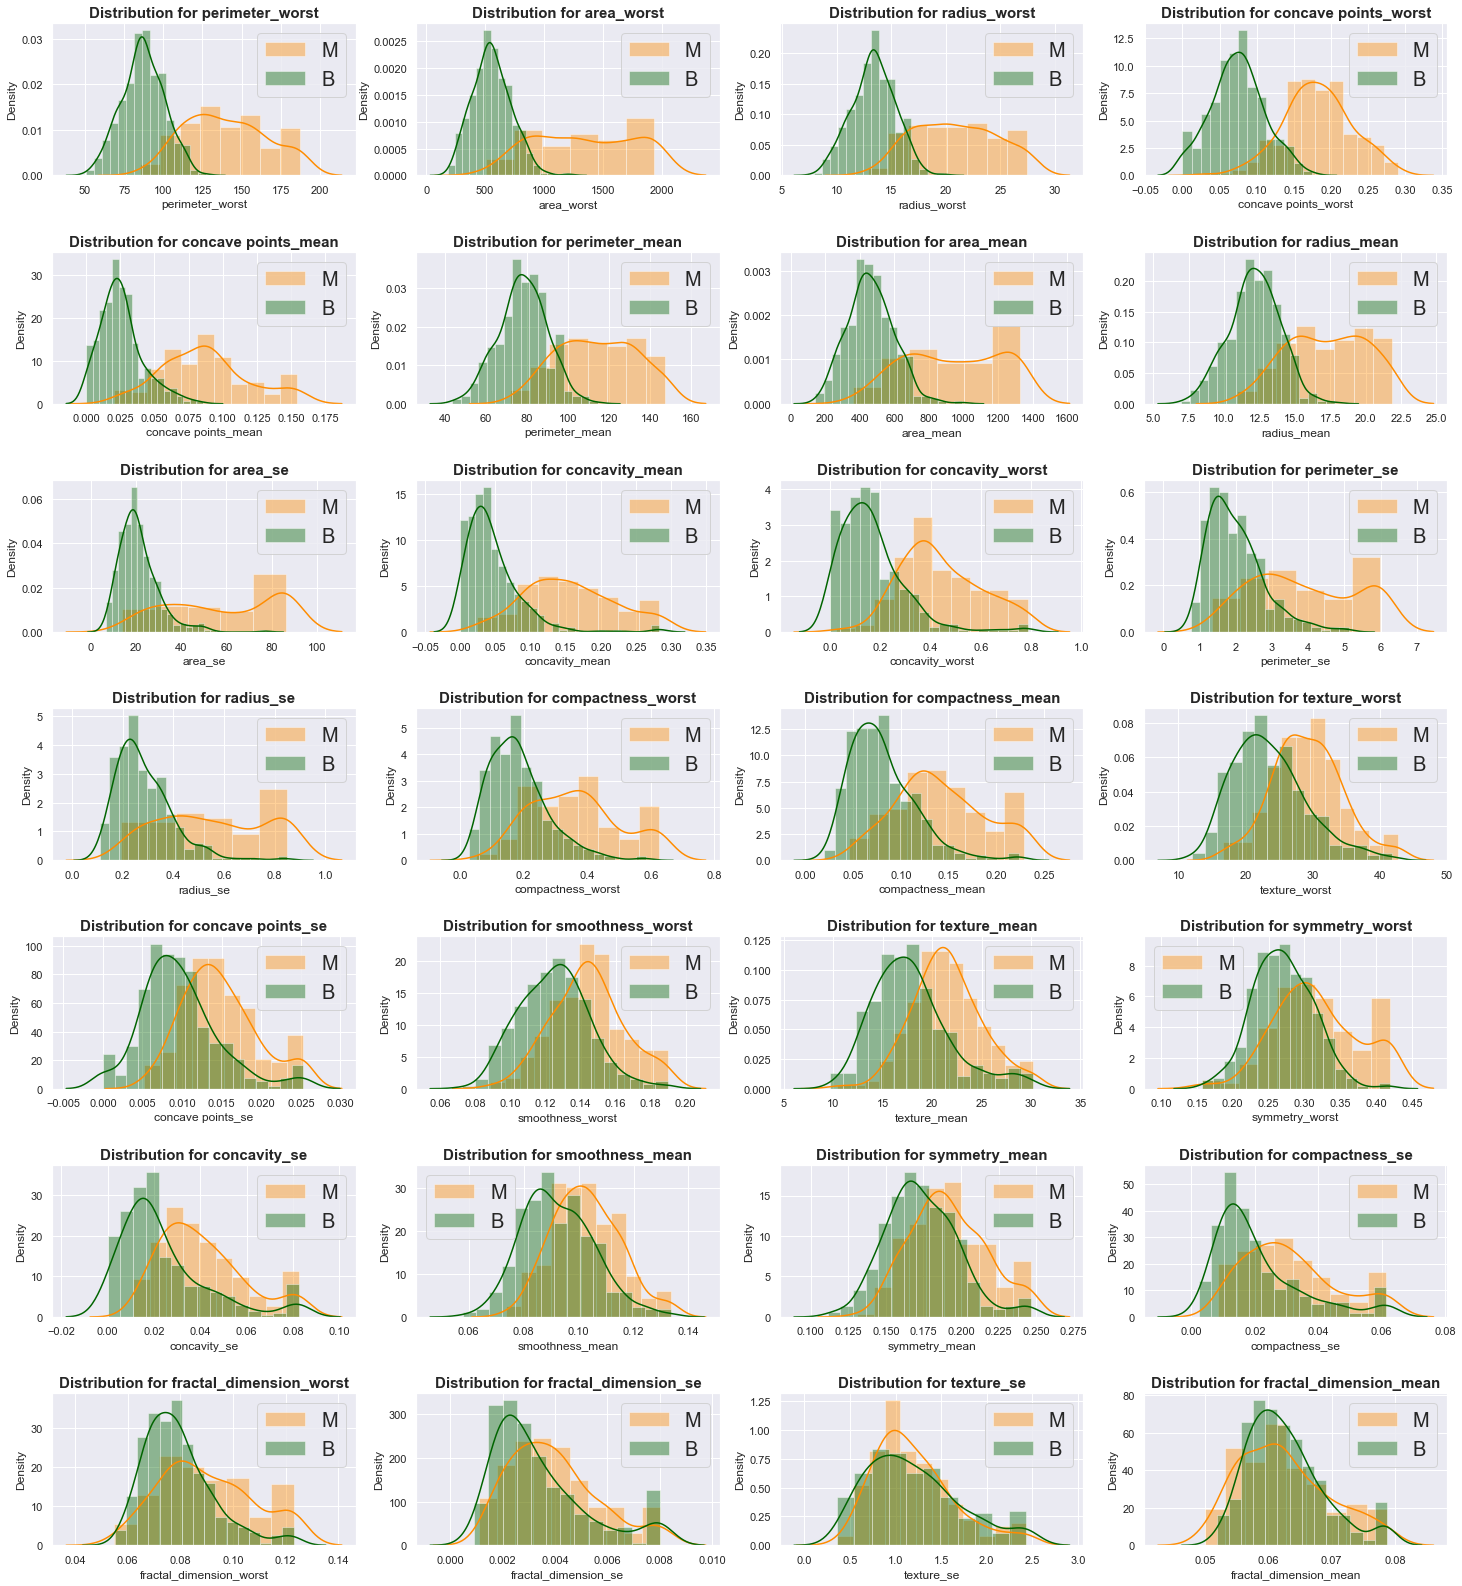

In [80]:
num_feat = x.shape[1]-1
fig = plt.figure(figsize=(25, num_feat))
fig.subplots_adjust(hspace=.5)
axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

for i, column in enumerate(x.columns[1:]):
    sns.distplot(x[x.diagnosis == 1][column], ax=axs[i], color='darkorange', label="M")
    sns.distplot(x[x.diagnosis == 0][column], ax=axs[i], color='darkgreen', label="B")
    axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
    axs[i].legend(fontsize=20)
plt.show()

## Normalize the data

In [81]:
features = x.iloc[:, 1:]
features

,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,184.60,1937.05,25.38,0.27,0.15,122.80,1001.00,17.99,86.20,0.28,0.71,5.98,0.85,0.63,0.23,17.33,0.02,0.16,10.38,0.42,0.05,0.12,0.24,0.05,0.12,0.01,0.91,0.08
1,158.80,1937.05,24.99,0.19,0.07,132.90,1326.00,20.57,74.08,0.09,0.24,3.40,0.54,0.19,0.08,23.41,0.01,0.12,17.77,0.28,0.02,0.08,0.18,0.01,0.09,0.00,0.73,0.06
2,152.50,1709.00,23.57,0.24,0.13,130.00,1203.00,19.69,86.20,0.20,0.45,4.58,0.75,0.42,0.16,25.53,0.02,0.14,21.25,0.36,0.04,0.11,0.21,0.04,0.09,0.00,0.79,0.06
3,98.87,567.70,14.91,0.26,0.11,77.58,386.10,11.42,27.23,0.24,0.69,3.44,0.50,0.63,0.23,26.50,0.02,0.19,20.38,0.42,0.06,0.13,0.25,0.06,0.12,0.01,1.16,0.08
4,152.20,1575.00,22.54,0.16,0.10,135.10,1297.00,20.29,86.20,0.20,0.40,5.44,0.76,0.20,0.13,16.67,0.02,0.14,14.34,0.24,0.06,0.10,0.18,0.02,0.08,0.01,0.78,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,166.10,1937.05,25.45,0.22,0.14,142.00,1326.30,21.56,86.20,0.24,0.41,5.98,0.85,0.21,0.12,26.40,0.02,0.14,22.39,0.21,0.05,0.11,0.17,0.03,0.07,0.00,1.26,0.06
565,155.00,1731.00,23.69,0.16,0.10,131.20,1261.00,20.13,86.20,0.14,0.32,5.20,0.77,0.19,0.10,38.25,0.02,0.12,28.25,0.26,0.04,0.10,0.18,0.02,0.07,0.00,2.43,0.06
566,126.70,1124.00,18.98,0.14,0.05,108.30,858.10,16.60,48.55,0.09,0.34,3.42,0.46,0.31,0.10,34.12,0.02,0.11,28.08,0.22,0.05,0.08,0.16,0.04,0.08,0.00,1.07,0.06
567,184.60,1821.00,25.74,0.27,0.15,140.10,1265.00,20.60,86.20,0.28,0.79,5.77,0.73,0.63,0.23,39.42,0.02,0.17,29.33,0.41,0.07,0.12,0.24,0.06,0.12,0.01,1.59,0.07


In [82]:
normal_data = sn.scale_and_normalize(features, features.columns.to_list())
normal_data.insert(loc=0, column='diagnosis', value=x['diagnosis'])
normal_data

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,0.22,0.22,0.20,0.20,0.21,0.17,0.16,0.16,0.22,0.22,0.20,0.22,0.22,0.22,0.22,0.04,0.14,0.17,0.01,0.22,0.15,0.18,0.22,0.18,0.21,0.17,0.06,0.22
1,1,0.26,0.33,0.29,0.21,0.15,0.28,0.33,0.30,0.28,0.10,0.10,0.17,0.19,0.09,0.09,0.12,0.18,0.14,0.13,0.15,0.07,0.12,0.17,0.06,0.17,0.12,0.06,0.08
2,1,0.20,0.23,0.21,0.22,0.22,0.22,0.24,0.23,0.27,0.19,0.15,0.20,0.23,0.18,0.18,0.12,0.22,0.16,0.15,0.21,0.12,0.18,0.19,0.17,0.13,0.14,0.06,0.09
3,1,0.09,0.06,0.09,0.22,0.17,0.08,0.05,0.08,0.07,0.22,0.22,0.13,0.13,0.25,0.25,0.12,0.19,0.25,0.13,0.25,0.17,0.25,0.25,0.25,0.25,0.25,0.10,0.25
4,1,0.22,0.23,0.22,0.16,0.20,0.26,0.29,0.26,0.29,0.21,0.15,0.26,0.26,0.09,0.16,0.04,0.22,0.16,0.07,0.09,0.20,0.16,0.15,0.11,0.09,0.17,0.06,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,0.22,0.26,0.23,0.20,0.23,0.25,0.26,0.25,0.26,0.22,0.14,0.26,0.26,0.08,0.12,0.12,0.25,0.15,0.16,0.05,0.16,0.18,0.12,0.12,0.06,0.12,0.11,0.06
565,1,0.22,0.25,0.23,0.16,0.18,0.24,0.27,0.25,0.28,0.14,0.12,0.24,0.25,0.08,0.11,0.24,0.19,0.11,0.25,0.11,0.14,0.15,0.13,0.10,0.05,0.06,0.28,0.05
566,1,0.21,0.20,0.21,0.18,0.13,0.23,0.23,0.24,0.20,0.12,0.16,0.19,0.18,0.18,0.15,0.27,0.23,0.13,0.33,0.09,0.21,0.13,0.13,0.22,0.13,0.16,0.13,0.08
567,1,0.20,0.19,0.19,0.19,0.20,0.19,0.20,0.19,0.21,0.21,0.21,0.20,0.17,0.21,0.21,0.19,0.14,0.16,0.20,0.20,0.18,0.16,0.20,0.21,0.21,0.15,0.12,0.15


In [83]:
%%time
sm = from_pandas(normal_data.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

Wall time: 22.4 s


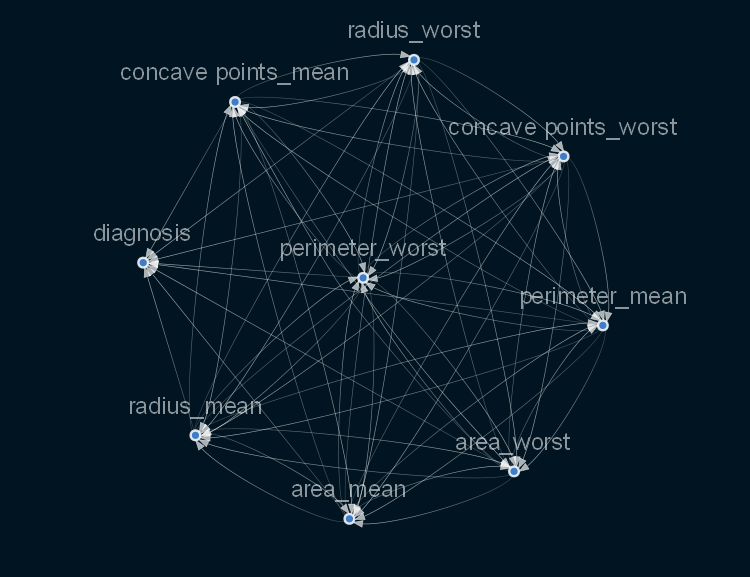

In [84]:
vs.vis_sm(sm)

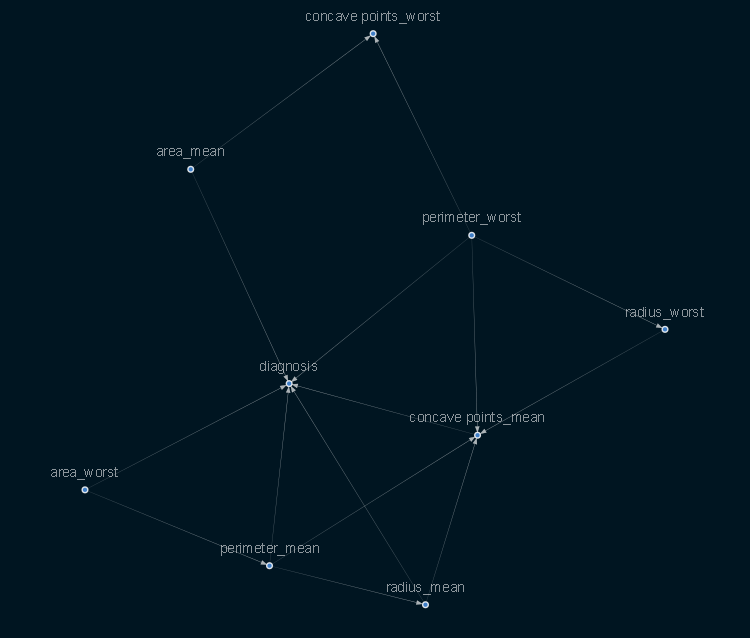

In [85]:
sm.remove_edges_below_threshold(0.8)
vs.vis_sm(sm)

## Stablity of causal graph


In [86]:
x_selected = normal_data.iloc[:, :10]

### 50%

In [87]:
portion = int(x_selected.shape[0] *.5)
x_portion = x_selected.head(portion)

Wall time: 19.5 s


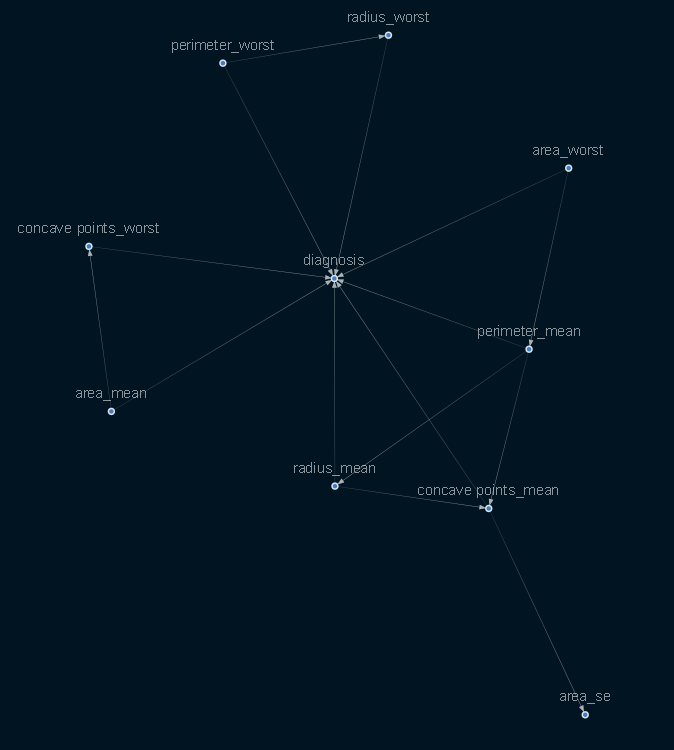

In [88]:
%%time
sm1 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm1.remove_edges_below_threshold(0.8)
sm1 = sm1.get_largest_subgraph()
vs.vis_sm(sm1)

In [89]:
print(sm1.edges)

[('perimeter_worst', 'diagnosis'), ('perimeter_worst', 'radius_worst'), ('area_worst', 'diagnosis'), ('area_worst', 'perimeter_mean'), ('radius_worst', 'diagnosis'), ('concave points_worst', 'diagnosis'), ('concave points_mean', 'diagnosis'), ('concave points_mean', 'area_se'), ('perimeter_mean', 'diagnosis'), ('perimeter_mean', 'concave points_mean'), ('perimeter_mean', 'radius_mean'), ('area_mean', 'diagnosis'), ('area_mean', 'concave points_worst'), ('radius_mean', 'diagnosis'), ('radius_mean', 'concave points_mean')]


# 60%

In [90]:
portion = int(x_selected.shape[0]*.6)
x_portion = x_selected.head(portion)

Wall time: 21.8 s


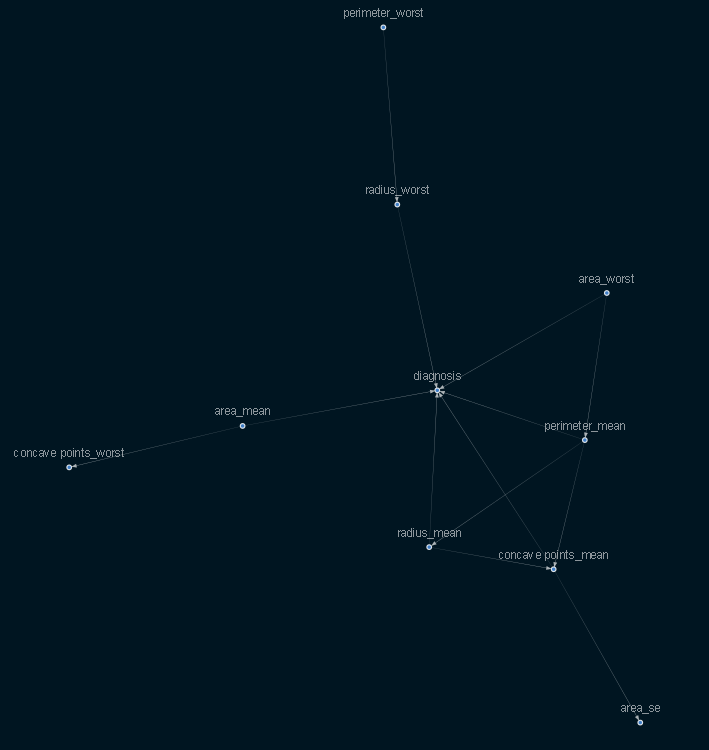

In [91]:
%%time
sm2 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm2.remove_edges_below_threshold(0.8)
sm2 = sm2.get_largest_subgraph()
vs.vis_sm(sm2)

In [92]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)), 3)

In [93]:
jaccard_similarity(sm1.edges, sm2.edges)

0.867

# 70%

In [94]:
portion = int(x_selected.shape[0]*.7)
x_portion = x_selected.head(portion)

Wall time: 20.2 s


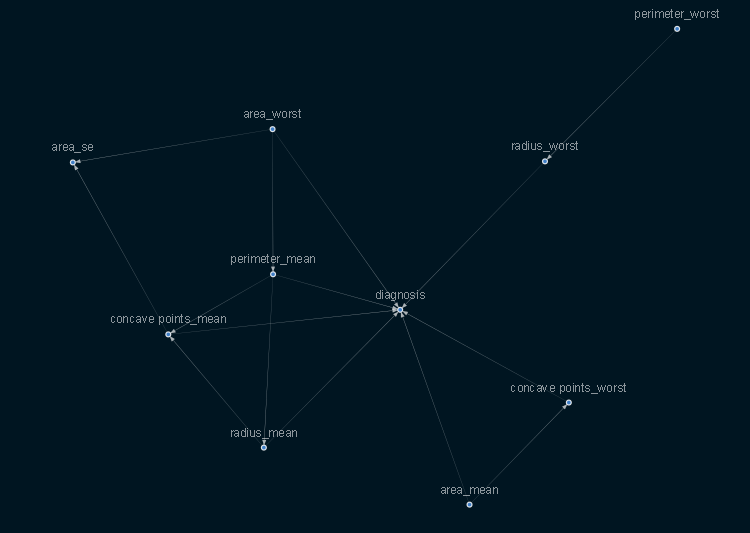

In [95]:
%%time
sm3 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm3.remove_edges_below_threshold(0.8)
sm3 = sm3.get_largest_subgraph()
vs.vis_sm(sm3)

In [96]:
jaccard_similarity(sm2.edges, sm3.edges)

0.867

# 80%

In [97]:
portion = int(x_selected.shape[0] * .8)
x_portion = x_selected.head(portion)

Wall time: 23.2 s


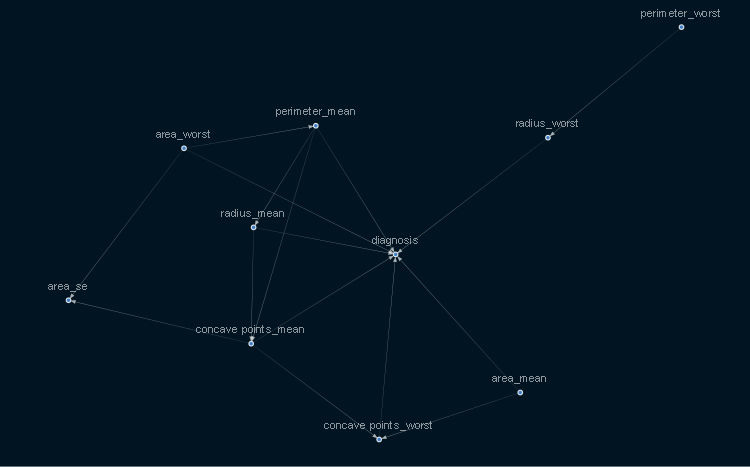

In [98]:
%%time
sm4 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm4.remove_edges_below_threshold(0.8)
sm4 = sm4.get_largest_subgraph()
vs.vis_sm(sm4)

In [99]:
jaccard_similarity(sm3.edges, sm4.edges)

0.938

# 90%

In [100]:
portion = int(x_selected.shape[0] * .9)
x_portion = x_selected.head(portion)

Wall time: 22 s


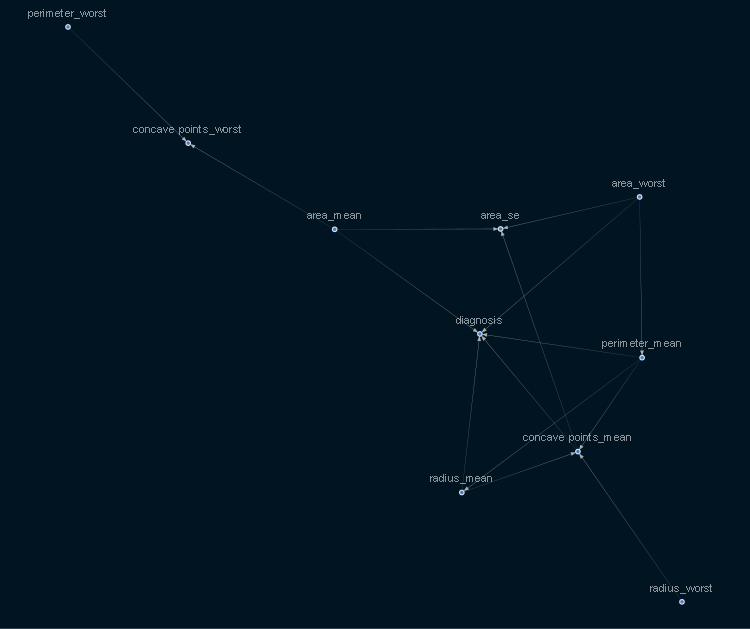

In [101]:
%%time
sm5 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm5.remove_edges_below_threshold(0.8)
sm5 = sm5.get_largest_subgraph()
vs.vis_sm(sm5)

Casual Inference model for breast cancer

In [102]:
jaccard_similarity(sm5.edges, sm4.edges)

0.632

# 100%

Wall time: 20.7 s


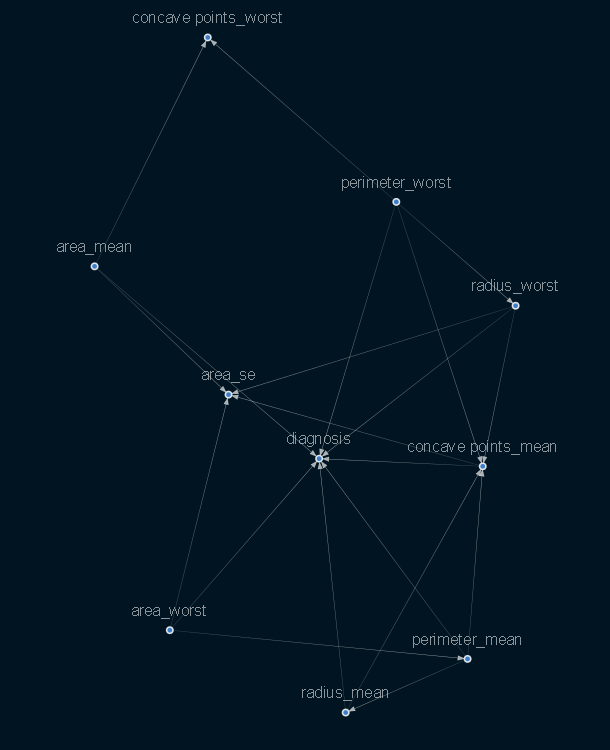

In [103]:
%%time
sm = from_pandas(x_selected, tabu_parent_nodes=['diagnosis'],)
sm.remove_edges_below_threshold(0.8)
sm = sm.get_largest_subgraph()
vs.vis_sm(sm)

In [104]:
jaccard_similarity(sm.edges, sm5.edges)

0.75

## Reducing a graph to its Markov Blanket

Now, assume that target is our variable of interest. We actually do not need all the nodes in the network but only the MB of target. To achieve that, we simply need to use the get_markov_blanket function from causalnex. Specifically,

In [138]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)
edge_list = list(bn.edges)
edge_list
#blanket = get_markov_blanket(bn, 'diagnosis')
#edge_list = list(blanket.structure.edges)
#edge_list

[('perimeter_worst', 'diagnosis'),
 ('perimeter_worst', 'radius_worst'),
 ('perimeter_worst', 'concave points_worst'),
 ('perimeter_worst', 'concave points_mean'),
 ('radius_worst', 'diagnosis'),
 ('radius_worst', 'concave points_mean'),
 ('radius_worst', 'area_se'),
 ('concave points_mean', 'diagnosis'),
 ('concave points_mean', 'area_se'),
 ('area_worst', 'diagnosis'),
 ('area_worst', 'perimeter_mean'),
 ('area_worst', 'area_se'),
 ('perimeter_mean', 'diagnosis'),
 ('perimeter_mean', 'concave points_mean'),
 ('perimeter_mean', 'radius_mean'),
 ('radius_mean', 'diagnosis'),
 ('radius_mean', 'concave points_mean'),
 ('area_mean', 'diagnosis'),
 ('area_mean', 'concave points_worst'),
 ('area_mean', 'area_se')]

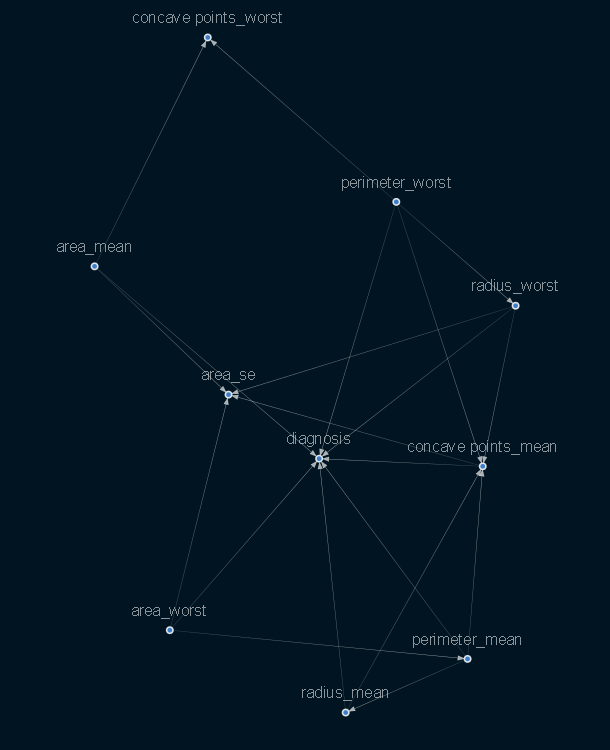

In [139]:
vs.vis_sm(bn.structure)

## Discretising Numeric Features

In [140]:
x_selected = x.iloc[:, :10]
x_selected

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se
0,1,184.60,1937.05,25.38,0.27,0.15,122.80,1001.00,17.99,86.20
1,1,158.80,1937.05,24.99,0.19,0.07,132.90,1326.00,20.57,74.08
2,1,152.50,1709.00,23.57,0.24,0.13,130.00,1203.00,19.69,86.20
3,1,98.87,567.70,14.91,0.26,0.11,77.58,386.10,11.42,27.23
4,1,152.20,1575.00,22.54,0.16,0.10,135.10,1297.00,20.29,86.20
...,...,...,...,...,...,...,...,...,...,...
564,1,166.10,1937.05,25.45,0.22,0.14,142.00,1326.30,21.56,86.20
565,1,155.00,1731.00,23.69,0.16,0.10,131.20,1261.00,20.13,86.20
566,1,126.70,1124.00,18.98,0.14,0.05,108.30,858.10,16.60,48.55
567,1,184.60,1821.00,25.74,0.27,0.15,140.10,1265.00,20.60,86.20


In [141]:
df_overview = DfOverview(x_selected)
overview = df_overview.getOverview()
vs.view_df(overview[["count", "unique_value_count", "unique_percentage"]],
                    ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,2,0.35%
1,PERIMETER_WORST,569,500,87.87%
2,AREA_WORST,569,510,89.63%
3,RADIUS_WORST,569,441,77.5%
4,CONCAVE POINTS_WORST,569,492,86.47%
5,CONCAVE POINTS_MEAN,569,533,93.67%
6,PERIMETER_MEAN,569,511,89.81%
7,AREA_MEAN,569,515,90.51%
8,RADIUS_MEAN,569,443,77.86%
9,AREA_SE,569,465,81.72%


In [142]:
features = list(x_selected.columns.difference(['diagnosis']))
features

['area_mean',
 'area_se',
 'area_worst',
 'concave points_mean',
 'concave points_worst',
 'perimeter_mean',
 'perimeter_worst',
 'radius_mean',
 'radius_worst']

In [143]:
tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
    mode='single',
    tree_params={'max_depth': 3, 'random_state': 27},
)
tree_discretiser.fit(
    feat_names=features,
    dataframe=x,
    target_continuous=True,
    target='diagnosis',
)
tree_discretiser

DecisionTreeSupervisedDiscretiserMethod(tree_params={'max_depth': 3,
                                                     'random_state': 27})

In [144]:
discretised_data = x_selected.copy()
for col in features:
    discretised_data[col] = tree_discretiser.transform(x_selected[[col]])


In [145]:
df_overview = DfOverview(discretised_data)
overview = df_overview.getOverview()
vs.view_df(overview[["count", "unique_value_count", "unique_percentage"]],
           ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,2,0.35%
1,PERIMETER_WORST,569,8,1.41%
2,AREA_WORST,569,8,1.41%
3,RADIUS_WORST,569,8,1.41%
4,CONCAVE POINTS_WORST,569,8,1.41%
5,CONCAVE POINTS_MEAN,569,8,1.41%
6,PERIMETER_MEAN,569,8,1.41%
7,AREA_MEAN,569,8,1.41%
8,RADIUS_MEAN,569,8,1.41%
9,AREA_SE,569,8,1.41%


## Train Test Split

In [146]:
train, test = train_test_split( discretised_data, train_size=0.8, test_size=0.2, random_state=27)

## Bayesian Network

In [147]:
bn = BayesianNetwork(bn.structure)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [148]:
pred = bn.predict(test, 'diagnosis')
true = test['diagnosis']
pred

,diagnosis_prediction
191,0
120,0
535,1
282,1
463,0
...,...
492,1
182,1
443,0
507,0


In [149]:
print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=pred)))
print('F1: {:.2f} '.format(f1_score(y_true=true, y_pred=pred)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Recall: 0.64
F1: 0.78 
Accuracy: 0.86 
Precision: 1.00 
